In [1]:
from __future__ import print_function
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

## Genomics example

This will explore how importance scores from three different methods compare on simulated genomic data.

The simulated data was as follows:

- 1/4 sequences with 1-3 instances of a GATA_disc1 motif embedded (see http://compbio.mit.edu/encode-motifs/ for the PWM); these were labelled 1,0,0
- 1/4 sequences with 1-3 instances of a TAL1_known1 motif embedded; these were labelled 0,1,0
- 1/4 sequences with BOTH 1-3 instances of a GATA_disc1 motif AND 1-3 instances of a TAL1_known1 motif; these were labelled 1,1,1
- 1/4 sequences with no motif

Scores for all three tasks for sequences that contain both TAL1_known1 and GATA_disc1 motifs are analyzed in this notebook

### Read in and one-hot encode the data

In [3]:
import gzip
import re
from collections import OrderedDict

def load_sequences(seqfile):
        seqs = OrderedDict()
        fp = gzip.open(seqfile, "rb")
        print("#Loading " + seqfile + " ...")
        expecting = "label"
        label=''
        for line in fp:
                if expecting == "label":
                        match = re.match(">(.*)$", line)
                        if match:
                                label = match.group(1)
                                expecting = "sequence"
                        else:
                                print("Expecting LABEL but found (!!): " + line)
                                continue
                else:
                        match = re.match("(\w+)$", line)
                        if match:
                                sequence = match.group(1)
                                seqs[label]=sequence
                        else:
                                print("Expecting SEQUENCE but found (!!): " + line)
                        expecting = "label"
                        label=''
        fp.close()
        print("#Loaded " + str(len(seqs.keys())) + " sequences from " + seqfile)
        return seqs

In [4]:
def load_sequences_from_bedfile(seqfile):
    seqs = OrderedDict()
    fp = gzip.open(seqfile, "rb")
    print("#Loading " + seqfile + " ...")
    for line in fp:
        (label, sequence)=line.split()
        seqs[label]=sequence
    fp.close()
    print("#Loaded " + str(len(seqs.keys())) + " sequences from " + seqfile)
    return seqs
    

In [5]:
def get_value(label):
    value = -1
    match = re.match("((dinuc_shuff_|dinuc_shuffled_).+)$", label)
    if match:            
        chrom = match.group(1)
        if match.group(2) == 'dinuc_shuff_':
            value = 0
        else:
            value = 1
    return value        

In [6]:
import random
def get_random_set(seqdict, num, sort=True):
    newlist=seqdict.items()
    if sort:
        newlist = [newlist[i] for i in sorted(random.sample(range(len(newlist)), num))]
    else:
        newlist = [newlist[i] for i in random.sample(range(len(newlist)), num)]
    return dict(newlist)

In [7]:
import numpy as np

data_filename_positive = "/users/eprakash/projects/benchmarking/newdata/GM12878/400bp/GM12878.400bp.summits.implanted.bed.gz"
data_filename_negative = "/users/eprakash/projects/benchmarking/newdata/GM12878/400bp/universal_dnase.matched.GM12878.summits.400bp.hg38.implanted.bed.gz"
positives=load_sequences_from_bedfile(data_filename_positive)
labeled_sequences = load_sequences_from_bedfile(data_filename_positive)
#del labeled_sequences['chr1:203649072-203650072']
print("Got %d positive sequences" % len(labeled_sequences))
positive_labels = labeled_sequences.keys()
neg_seqs = load_sequences_from_bedfile(data_filename_negative)
#del neg_seqs['chr1:203649072-203650072']
#neg_seqs = get_random_set(neg_seqs, 200000)
print("Got %d negative sequences" % len(neg_seqs))
negative_labels = neg_seqs.keys()
print("Number of labels common to both sets of sequences is %d " % len(set(positive_labels).intersection(set(negative_labels))))
labeled_sequences.update(neg_seqs)
labeled_sequences=get_random_set(labeled_sequences, 74499, sort=False)
labels = labeled_sequences.keys()
sequences=labeled_sequences.values()
#values = np.array([get_value(label) for label in labels])
#check_negatives = np.nonzero(values == -1)[0]
#assert (len(check_negatives) == 0)
#print("Labels length: ", len(labels))
print("Sequences length: ", len(sequences))
#print("Values length: ", len(values))

#Loading /users/eprakash/projects/benchmarking/newdata/GM12878/400bp/GM12878.400bp.summits.implanted.bed.gz ...
#Loaded 68407 sequences from /users/eprakash/projects/benchmarking/newdata/GM12878/400bp/GM12878.400bp.summits.implanted.bed.gz
#Loading /users/eprakash/projects/benchmarking/newdata/GM12878/400bp/GM12878.400bp.summits.implanted.bed.gz ...
#Loaded 68407 sequences from /users/eprakash/projects/benchmarking/newdata/GM12878/400bp/GM12878.400bp.summits.implanted.bed.gz
Got 68407 positive sequences
#Loading /users/eprakash/projects/benchmarking/newdata/GM12878/400bp/universal_dnase.matched.GM12878.summits.400bp.hg38.implanted.bed.gz ...
#Loaded 68407 sequences from /users/eprakash/projects/benchmarking/newdata/GM12878/400bp/universal_dnase.matched.GM12878.summits.400bp.hg38.implanted.bed.gz
Got 68407 negative sequences
Number of labels common to both sets of sequences is 0 
Sequences length:  74499


In [8]:
removed=[]
chars=['R','Y','S','W','K','M','B','D','H','V','N']
print(len(sequences))
for seq in sequences:
    if any((c in chars) for c in seq):
        removed.append(seq)
        sequences.remove(seq)
print(len(sequences))

74499
74493


In [9]:
for i in removed:
    key=labeled_sequences.keys()[labeled_sequences.values().index(i)]
    print(key)
    del labeled_sequences[key]
    labels.remove(key)
print (len(labels))
print(len(labeled_sequences))

dinuc_shuffled_motifs_implanted_chr10:114305780-114306180
dinuc_shuffled_motifs_implanted_chr1:248752148-248752548
dinuc_shuffled_motifs_implanted_chr17:25919997-25920397
dinuc_shuffled_motifs_implanted_chr1:9828-10228
dinuc_shuffled_motifs_implanted_chr17:489269-489669
dinuc_shuffled_motifs_implanted_chr9:41229356-41229756
74493
74493


One-hot encode the data

In [10]:
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
#sequences = sequences[-5000:]            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in sequences])

In [11]:
print(onehot_data.shape)

(74493, 400, 4)


### Load the keras model

In [12]:
import keras

keras.__version__

Using TensorFlow backend.


'2.2.5'

In [13]:

import deeplift
import tensorflow as tf
from keras.models import model_from_json
from keras.models import load_model

keras_model = load_model('/users/eprakash/projects/benchmarking/notebooks/momma_dragonn/adaptDeepSeaKerasModel.h5')
keras_model.summary()
'''
with tf.device('/gpu:3'):
#load the keras model
    keras_model_weights = "/users/eprakash/git/momma_dragonn/examples/fasta_sequential_model/model_files/record_6_model_6uIHH_modelWeights.h5"
    keras_model_json = "/users/eprakash/git/momma_dragonn/examples/fasta_sequential_model/model_files/record_6_model_6uIHH_modelJson.json"

    keras_model = model_from_json(open(keras_model_json).read())
    keras_model.load_weights(keras_model_weights)
    keras_model=load_h5_model('/users/eprakash/projects/benchmarking/notebooks/momma_dragonn/deepseabeluga_keras.h5')'''

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 393, 320)          10560     
_________________________________________________________________
activation_1 (Activation)    (None, 393, 320)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 386, 320)          819520    
_________________________________________________________________
activation_2 (Activation)    (None, 386, 320)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 386, 320)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 96, 320)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 89, 480)          

/users/eprakash/anaconda2/lib/python2.7/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


'\nwith tf.device(\'/gpu:3\'):\n#load the keras model\n    keras_model_weights = "/users/eprakash/git/momma_dragonn/examples/fasta_sequential_model/model_files/record_6_model_6uIHH_modelWeights.h5"\n    keras_model_json = "/users/eprakash/git/momma_dragonn/examples/fasta_sequential_model/model_files/record_6_model_6uIHH_modelJson.json"\n\n    keras_model = model_from_json(open(keras_model_json).read())\n    keras_model.load_weights(keras_model_weights)\n    keras_model=load_h5_model(\'/users/eprakash/projects/benchmarking/notebooks/momma_dragonn/deepseabeluga_keras.h5\')'

In [14]:
preds = keras_model.predict(onehot_data)

In [15]:
print (len(sequences))

74493


In [16]:
true_labels=[]
for label in labels:
    if label in positive_labels:
        true_labels.append(1)
    elif label in negative_labels:
        true_labels.append(0)
    else:
        continue
print(len(true_labels))

74493


In [17]:
preds.shape[1]

2002

In [18]:
from sklearn.metrics import roc_auc_score
aurocs=np.zeros((preds.shape[1]))
print(aurocs.shape)
for i in range(0,preds.shape[1]):
    auroc = roc_auc_score(y_true=true_labels, y_score=preds[:,i])
    aurocs[i]=auroc

(2002,)


In [19]:
print(max(aurocs))

0.9297967508629117


In [20]:
seq_id_to_pred={}
for index in range(0,len(labels)):
    label=labels[index]
    if label in positive_labels:
        seq_id_to_pred.update({label:preds[index][0]})
print(len(seq_id_to_pred))
print(len(positive_labels))

37191
68407


In [21]:
top_1k_pos_labels=sorted(seq_id_to_pred, key=lambda x: seq_id_to_pred[x])[-1000:]
top_1k_pos=[]
for label in top_1k_pos_labels:
    top_1k_pos.append(positives[label])
print(len(top_1k_pos_labels))
print(top_1k_pos_labels[0:5])

1000
['dinuc_shuffled_motifs_implanted_chr19:49527665-49528065', 'dinuc_shuffled_motifs_implanted_chr9:20941048-20941448', 'dinuc_shuffled_motifs_implanted_chr9:136886165-136886565', 'dinuc_shuffled_motifs_implanted_chr15:73633311-73633711', 'dinuc_shuffled_motifs_implanted_chr1:174159272-174159672']


In [22]:
print(seq_id_to_pred.items()[0:5])

[('dinuc_shuffled_motifs_implanted_chr14:49861710-49862110', 0.29643485), ('dinuc_shuffled_motifs_implanted_chr1:40373932-40374332', 0.43047956), ('dinuc_shuffled_motifs_implanted_chr19:8308372-8308772', 0.47756767), ('dinuc_shuffled_motifs_implanted_chr19:32971909-32972309', 0.6820805), ('dinuc_shuffled_motifs_implanted_chr10:119313634-119314034', 0.3153002)]


In [23]:
import h5py

h5f = h5py.File('/users/eprakash/projects/benchmarking/notebooks/momma_dragonn/top1kposlabels_GM12878_1kb', 'w')
h5f.create_dataset("labels", data=top_1k_pos_labels)
h5f.close()

## Prepare the deeplift models

### Model conversion

Convert the keras models to deeplift models capable of computing importance scores using DeepLIFT (with 3 different variants: rescale on the conv layers and revealcancel on the fully-connected layers (the genomics default), rescale on all layers, and revealcancel on all layers), gradients and guided backprop


In [24]:
keras_model.save_weights('gm12878_weights.h5')
with open('gm12878_model_architecture.json', 'w') as f:
    f.write(keras_model.to_json())

In [25]:
keras_model_weights='gm12878_weights.h5'
keras_model_json='gm12878_model_architecture.json'

In [26]:
from deeplift.layers import NonlinearMxtsMode
import deeplift.conversion.kerasapi_conversion as kc
reload(deeplift.layers)
reload(deeplift.conversion.kerasapi_conversion)
from collections import OrderedDict

method_to_model = OrderedDict()
for method_name, nonlinear_mxts_mode in [
    #The genomics default = rescale on conv layers, revealcance on fully-connected
    ('rescale_conv_revealcancel_fc', NonlinearMxtsMode.DeepLIFT_GenomicsDefault),
    ('rescale_all_layers', NonlinearMxtsMode.Rescale),
    ('revealcancel_all_layers', NonlinearMxtsMode.RevealCancel),
    ('grad_times_inp', NonlinearMxtsMode.Gradient),
    ('guided_backprop', NonlinearMxtsMode.GuidedBackprop)]:
    method_to_model[method_name] = kc.convert_model_from_saved_files(
        h5_file=keras_model_weights,
        json_file=keras_model_json,
        nonlinear_mxts_mode=nonlinear_mxts_mode)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 3 the preceding linear layer is 2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 7 the preceding linear layer is 6 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 9 the preceding linear layer is 8 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 13 the preceding lin

### Sanity checks
To ensure that the conversion happend correctly, ensure that the models give identical predictions

If you are using a functional model, see this issue for how to adapt the code: https://github.com/kundajelab/deeplift/issues/54

In [27]:
#make sure predictions are the same as the original model
from deeplift.util import compile_func
model_to_test = method_to_model['rescale_conv_revealcancel_fc']
deeplift_prediction_func = compile_func([model_to_test.get_layers()[0].get_activation_vars()],
                                         model_to_test.get_layers()[-1].get_activation_vars())
original_model_predictions = keras_model.predict(onehot_data, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[onehot_data],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
print("maximum difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions

maximum difference in predictions: 0.0


## Compute importance scores

### Compile various scoring functions
Using the deeplift models, we obtain the functions capable of computing the importance scores.

In [28]:
print("Compiling scoring functions")
method_to_scoring_func = OrderedDict()
for method,model in method_to_model.items():
    print("Compiling scoring function for: "+method)
    method_to_scoring_func[method] = model.get_target_contribs_func(find_scores_layer_idx=0,
                                                                    target_layer_idx=-2)
    
#To get a function that just gives the gradients, we use the multipliers of the Gradient model
gradient_func = method_to_model['grad_times_inp'].get_target_multipliers_func(find_scores_layer_idx=0,
                                                                              target_layer_idx=-2)
print("Compiling integrated gradients scoring functions")
integrated_gradients10_func = deeplift.util.get_integrated_gradients_function(
    gradient_computation_function = gradient_func,
    num_intervals=10)
method_to_scoring_func['integrated_gradients10'] = integrated_gradients10_func

Compiling scoring functions
Compiling scoring function for: rescale_conv_revealcancel_fc
Compiling scoring function for: rescale_all_layers
Compiling scoring function for: revealcancel_all_layers
Compiling scoring function for: grad_times_inp
Compiling scoring function for: guided_backprop
Compiling integrated gradients scoring functions


### Call scoring functions on the data

In the cell below, a reference representing 40% GC content is used

In [29]:
background = OrderedDict([('A', 0.0), ('C', 0.0), ('G', 0.0), ('T', 0.0)])

from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
print (method_to_scoring_func.keys())
for method_name, score_func in method_to_scoring_func.items():
    print("on method",method_name)
    print("scorefunc ", score_func)
    if (not method_name == "grad_times_inp"):
        continue
    method_to_task_to_scores[method_name] = OrderedDict()
    for task_idx in [0]:
        scores = np.array(score_func(
        task_idx=task_idx,
        input_data_list=[onehot_data],
        input_references_list=[
        np.array([background['A'],
                background['C'],
                background['G'],
                background['T']])[None,None,:]],
                batch_size=200,
                progress_update=None))
        assert scores.shape[2]==4
        #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
        # assigns contributions based on difference-from-reference; if
        # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0.3, 0.2, 0.2, 0.3]
        # in the reference, importance will be assigned to the difference (1-0.3)
        # in the 'A' channel, (0-0.2) in the 'C' channel,
        # (0-0.2) in the G channel, and (0-0.3) in the T channel. You want to take the importance
        # on all four channels and sum them up, so that at visualization-time you can project the
        # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
        # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
        # every position and you won't know which base is the one that is actually present in the sequence!
        scores = np.sum(scores, axis=2)
        method_to_task_to_scores[method_name][task_idx] = scores

['rescale_conv_revealcancel_fc', 'rescale_all_layers', 'revealcancel_all_layers', 'grad_times_inp', 'guided_backprop', 'integrated_gradients10']
on method rescale_conv_revealcancel_fc
scorefunc  <function func at 0x7fe9a80ebcf8>
on method rescale_all_layers
scorefunc  <function func at 0x7fe987cad050>
on method revealcancel_all_layers
scorefunc  <function func at 0x7fe987cad2a8>
on method grad_times_inp
scorefunc  <function func at 0x7fe9872a0500>
on method guided_backprop
scorefunc  <function func at 0x7fe91bcb9230>
on method integrated_gradients10
scorefunc  <function compute_integrated_gradients at 0x7fe8e7a2f9b0>


In [30]:
print(scores.shape)

(74493, 400)


## Using multiple shuffled references

As an alternative to using a flat reference based on GC content (which can sometimes produce artefacts), we propose averaging the scores produced using mutliple references which are produced by shuffling the original sequence. We find in practice that this can give more robust results. Note that in general, the optimal choice of reference is an area of active research.

In [31]:
reload(deeplift.util)
from deeplift.util import get_shuffle_seq_ref_function
#from deeplift.util import randomly_shuffle_seq
from deeplift.dinuc_shuffle import dinuc_shuffle #function to do a dinucleotide shuffle

rescale_conv_revealcancel_fc_many_refs_func = get_shuffle_seq_ref_function(
    #score_computation_function is the original function to compute scores
    score_computation_function=method_to_scoring_func['rescale_conv_revealcancel_fc'],
    #shuffle_func is the function that shuffles the sequence
    #technically, given the background of this simulation, randomly_shuffle_seq
    #makes more sense. However, on real data, a dinuc shuffle is advisable due to
    #the strong bias against CG dinucleotides
    shuffle_func=dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(seq) for seq in x]))

num_refs_per_seq=10 #number of references to generate per sequence
method_to_task_to_scores['rescale_conv_revealcancel_fc_multiref_'+str(num_refs_per_seq)] = OrderedDict()
for task_idx in [0]:
    #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
    # assigns contributions based on difference-from-reference; if
    # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0, 1, 0, 0]
    # in the reference, importance will be assigned to the difference (1-0)
    # in the 'A' channel, and (0-1) in the 'C' channel. You want to take the importance
    # on all channels and sum them up, so that at visualization-time you can project the
    # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
    # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
    # every position and you won't know which base is the one that is actually present in the sequence!
    method_to_task_to_scores['rescale_conv_revealcancel_fc_multiref_'+str(num_refs_per_seq)][task_idx] =\
        np.sum(rescale_conv_revealcancel_fc_many_refs_func(
            task_idx=task_idx,
            input_data_sequences=sequences,
            num_refs_per_seq=num_refs_per_seq,
            batch_size=200,
            progress_update=1000,
        ),axis=2)

1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs generated
4000 reference seqs generated
5000 reference seqs generated
6000 reference seqs generated
7000 reference seqs generated
8000 reference seqs generated
9000 reference seqs generated
10000 reference seqs generated
11000 reference seqs generated
12000 reference seqs generated
13000 reference seqs generated
14000 reference seqs generated
15000 reference seqs generated
16000 reference seqs generated
17000 reference seqs generated
18000 reference seqs generated
19000 reference seqs generated
20000 reference seqs generated
21000 reference seqs generated
22000 reference seqs generated
23000 reference seqs generated
24000 reference seqs generated
25000 reference seqs generated
26000 reference seqs generated
27000 reference seqs generated
28000 reference seqs generated
29000 reference seqs generated
30000 reference seqs generated
31000 reference seqs generated
32000 reference seqs generated
33000 reference s

In [32]:
print(method_to_task_to_scores['rescale_conv_revealcancel_fc_multiref_10'][task_idx].shape)

(74493, 400)


In [33]:
reload(deeplift.util)
from deeplift.util import get_shuffle_seq_ref_function
#from deeplift.util import randomly_shuffle_seq
from deeplift.dinuc_shuffle import dinuc_shuffle #function to do a dinucleotide shuffle

rescale_all_layers_many_refs_func = get_shuffle_seq_ref_function(
    #score_computation_function is the original function to compute scores
    score_computation_function=method_to_scoring_func['rescale_all_layers'],
    #shuffle_func is the function that shuffles the sequence
    #technically, given the background of this simulation, randomly_shuffle_seq
    #makes more sense. However, on real data, a dinuc shuffle is advisable due to
    #the strong bias against CG dinucleotides
    shuffle_func=dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(seq) for seq in x]))

num_refs_per_seq=10 #number of references to generate per sequence
method_to_task_to_scores['rescale_all_layers_multiref_'+str(num_refs_per_seq)] = OrderedDict()
for task_idx in [0]:
    #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
    # assigns contributions based on difference-from-reference; if
    # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0, 1, 0, 0]
    # in the reference, importance will be assigned to the difference (1-0)
    # in the 'A' channel, and (0-1) in the 'C' channel. You want to take the importance
    # on all channels and sum them up, so that at visualization-time you can project the
    # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
    # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
    # every position and you won't know which base is the one that is actually present in the sequence!
    method_to_task_to_scores['rescale_all_layers_multiref_'+str(num_refs_per_seq)][task_idx] =\
        np.sum(rescale_all_layers_many_refs_func(
            task_idx=task_idx,
            input_data_sequences=sequences,
            num_refs_per_seq=num_refs_per_seq,
            batch_size=200,
            progress_update=1000,
        ),axis=2)

1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs generated
4000 reference seqs generated
5000 reference seqs generated
6000 reference seqs generated
7000 reference seqs generated
8000 reference seqs generated
9000 reference seqs generated
10000 reference seqs generated
11000 reference seqs generated
12000 reference seqs generated
13000 reference seqs generated
14000 reference seqs generated
15000 reference seqs generated
16000 reference seqs generated
17000 reference seqs generated
18000 reference seqs generated
19000 reference seqs generated
20000 reference seqs generated
21000 reference seqs generated
22000 reference seqs generated
23000 reference seqs generated
24000 reference seqs generated
25000 reference seqs generated
26000 reference seqs generated
27000 reference seqs generated
28000 reference seqs generated
29000 reference seqs generated
30000 reference seqs generated
31000 reference seqs generated
32000 reference seqs generated
33000 reference s

In [34]:
reload(deeplift.util)
from deeplift.util import get_shuffle_seq_ref_function
#from deeplift.util import randomly_shuffle_seq
from deeplift.dinuc_shuffle import dinuc_shuffle #function to do a dinucleotide shuffle

integrated_gradients10_many_refs_func = get_shuffle_seq_ref_function(
    #score_computation_function is the original function to compute scores
    score_computation_function=method_to_scoring_func['integrated_gradients10'],
    #shuffle_func is the function that shuffles the sequence
    #technically, given the background of this simulation, randomly_shuffle_seq
    #makes more sense. However, on real data, a dinuc shuffle is advisable due to
    #the strong bias against CG dinucleotides
    shuffle_func=dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(seq) for seq in x]))

num_refs_per_seq=10 #number of references to generate per sequence
method_to_task_to_scores['integrated_gradients10_multiref_'+str(num_refs_per_seq)] = OrderedDict()
for task_idx in [0,1,2]:
    #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
    # assigns contributions based on difference-from-reference; if
    # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0, 1, 0, 0]
    # in the reference, importance will be assigned to the difference (1-0)
    # in the 'A' channel, and (0-1) in the 'C' channel. You want to take the importance
    # on all channels and sum them up, so that at visualization-time you can project the
    # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
    # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
    # every position and you won't know which base is the one that is actually present in the sequence!
    method_to_task_to_scores['integrated_gradients10_multiref_'+str(num_refs_per_seq)][task_idx] =\
        np.sum(integrated_gradients10_many_refs_func(
            task_idx=task_idx,
            input_data_sequences=top_1k_pos,
            num_refs_per_seq=num_refs_per_seq,
            batch_size=200,
            progress_update=1000,
        ),axis=2)

1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs generated
4000 reference seqs generated
5000 reference seqs generated
6000 reference seqs generated
7000 reference seqs generated
8000 reference seqs generated
9000 reference seqs generated
10000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
Done 9000
Done 10000
Done 11000
Done 12000
Done 13000
Done 14000
Done 15000
Done 16000
Done 17000
Done 18000
Done 19000
Done 20000
Done 21000
Done 22000
Done 23000
Done 24000
Done 25000
Done 26000
Done 27000
Done 28000
Done 29000
Done 30000
Done 31000
Done 32000
Done 33000
Done 34000
Done 35000
Done 36000
Done 37000
Done 38000
Done 39000
Done 40000
Done 41000
Done 42000
Done 43000
Done 44000
Done 45000
Done 46000
Done 47000
Done 48000
Done 49000
Done 50000
Done 51000
Done 52000
Done 53000
Done 54000
Done 55000
Done 56000
Done 57000
Done 58000
Done 590

In [35]:
reload(deeplift.util)
from deeplift.util import get_shuffle_seq_ref_function
#from deeplift.util import randomly_shuffle_seq
from deeplift.dinuc_shuffle import dinuc_shuffle #function to do a dinucleotide shuffle

guided_backprop_many_refs_func = get_shuffle_seq_ref_function(
    #score_computation_function is the original function to compute scores
    score_computation_function=method_to_scoring_func['guided_backprop'],
    #shuffle_func is the function that shuffles the sequence
    #technically, given the background of this simulation, randomly_shuffle_seq
    #makes more sense. However, on real data, a dinuc shuffle is advisable due to
    #the strong bias against CG dinucleotides
    shuffle_func=dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(seq) for seq in x]))

num_refs_per_seq=10 #number of references to generate per sequence
method_to_task_to_scores['guided_backprop_multiref_'+str(num_refs_per_seq)] = OrderedDict()
for task_idx in [0,1,2]:
    #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
    # assigns contributions based on difference-from-reference; if
    # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0, 1, 0, 0]
    # in the reference, importance will be assigned to the difference (1-0)
    # in the 'A' channel, and (0-1) in the 'C' channel. You want to take the importance
    # on all channels and sum them up, so that at visualization-time you can project the
    # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
    # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
    # every position and you won't know which base is the one that is actually present in the sequence!
    method_to_task_to_scores['guided_backprop_multiref_'+str(num_refs_per_seq)][task_idx] =\
        np.sum(guided_backprop_many_refs_func(
            task_idx=task_idx,
            input_data_sequences=sequences,
            num_refs_per_seq=num_refs_per_seq,
            batch_size=200,
            progress_update=1000,
        ),axis=2)

1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs generated
4000 reference seqs generated
5000 reference seqs generated
6000 reference seqs generated
7000 reference seqs generated
8000 reference seqs generated
9000 reference seqs generated
10000 reference seqs generated
11000 reference seqs generated
12000 reference seqs generated
13000 reference seqs generated
14000 reference seqs generated
15000 reference seqs generated
16000 reference seqs generated
17000 reference seqs generated
18000 reference seqs generated
19000 reference seqs generated
20000 reference seqs generated
21000 reference seqs generated
22000 reference seqs generated
23000 reference seqs generated
24000 reference seqs generated
25000 reference seqs generated
26000 reference seqs generated
27000 reference seqs generated
28000 reference seqs generated
29000 reference seqs generated
30000 reference seqs generated
31000 reference seqs generated
32000 reference seqs generated
33000 reference s

In [37]:
reload(deeplift.util)
from deeplift.util import get_shuffle_seq_ref_function
#from deeplift.util import randomly_shuffle_seq
from deeplift.dinuc_shuffle import dinuc_shuffle #function to do a dinucleotide shuffle

revealcancel_all_layers_many_refs_func = get_shuffle_seq_ref_function(
    #score_computation_function is the original function to compute scores
    score_computation_function=method_to_scoring_func['revealcancel_all_layers'],
    #shuffle_func is the function that shuffles the sequence
    #technically, given the background of this simulation, randomly_shuffle_seq
    #makes more sense. However, on real data, a dinuc shuffle is advisable due to
    #the strong bias against CG dinucleotides
    shuffle_func=dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(seq) for seq in x]))

num_refs_per_seq=10 #number of references to generate per sequence
method_to_task_to_scores['revealcancel_all_layers_multiref_'+str(num_refs_per_seq)] = OrderedDict()
for task_idx in [0,1,2]:
    #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
    # assigns contributions based on difference-from-reference; if
    # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0, 1, 0, 0]
    # in the reference, importance will be assigned to the difference (1-0)
    # in the 'A' channel, and (0-1) in the 'C' channel. You want to take the importance
    # on all channels and sum them up, so that at visualization-time you can project the
    # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
    # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
    # every position and you won't know which base is the one that is actually present in the sequence!
    method_to_task_to_scores['revealcancel_all_layers_multiref_'+str(num_refs_per_seq)][task_idx] =\
        np.sum(revealcancel_all_layers_many_refs_func(
            task_idx=task_idx,
            input_data_sequences=sequences,
            num_refs_per_seq=num_refs_per_seq,
            batch_size=200,
            progress_update=1000,
        ),axis=2)

1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs generated
4000 reference seqs generated
5000 reference seqs generated
6000 reference seqs generated
7000 reference seqs generated
8000 reference seqs generated
9000 reference seqs generated
10000 reference seqs generated
11000 reference seqs generated
12000 reference seqs generated
13000 reference seqs generated
14000 reference seqs generated
15000 reference seqs generated
16000 reference seqs generated
17000 reference seqs generated
18000 reference seqs generated
19000 reference seqs generated
20000 reference seqs generated
21000 reference seqs generated
22000 reference seqs generated
23000 reference seqs generated
24000 reference seqs generated
25000 reference seqs generated
26000 reference seqs generated
27000 reference seqs generated
28000 reference seqs generated
29000 reference seqs generated
30000 reference seqs generated
31000 reference seqs generated
32000 reference seqs generated
33000 reference s

In [38]:
num_refs_per_seq=10 #number of references to generate per sequence
method_to_task_to_hypothetical_scores=OrderedDict()
method_to_task_to_hypothetical_scores.update({'rescale_conv_revealcancel_fc_multiref_'+str(num_refs_per_seq):OrderedDict()})
method_to_task_to_hypothetical_scores.update({"rescale_all_layers_multiref_"+str(num_refs_per_seq):OrderedDict()})

#for task_idx in [0]:
    #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
    # assigns contributions based on difference-from-reference; if
    # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0, 1, 0, 0]
    # in the reference, importance will be assigned to the difference (1-0)
    # in the 'A' channel, and (0-1) in the 'C' channel. You want to take the importance
    # on all channels and sum them up, so that at visualization-time you can project the
    # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
    # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
    # every position and you won't know which base is the one that is actually present in the sequence!
method_to_task_to_hypothetical_scores['rescale_conv_revealcancel_fc_multiref_'+str(num_refs_per_seq)] =\
    np.sum(method_to_hypothetical_scoring_func['rescale_conv_revealcancel_fc'](
    task_idx=task_idx,
    input_data_sequences=sequences,
    num_refs_per_seq=num_refs_per_seq,
    batch_size=200,
    progress_update=1000,
    ),axis=2)

NameError: name 'method_to_hypothetical_scoring_func' is not defined

In [ ]:
#for task_idx in [0]:
    #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
    # assigns contributions based on difference-from-reference; if
    # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0, 1, 0, 0]
    # in the reference, importance will be assigned to the difference (1-0)
    # in the 'A' channel, and (0-1) in the 'C' channel. You want to take the importance
    # on all channels and sum them up, so that at visualization-time you can project the
    # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
    # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
    # every position and you won't know which base is the one that is actually present in the sequence!
method_to_task_to_hypothetical_scores['rescale_all_layers_multiref_'+str(num_refs_per_seq)] =\
    np.sum(method_to_hypothetical_scoring_func['rescale_all_layers'](
    task_idx=task_idx,
    input_data_sequences=sequences,
    num_refs_per_seq=num_refs_per_seq,
    batch_size=200,
    progress_update=1000,
    ),axis=2)

### Save scores to HDF5 file

In [ ]:
print(method_to_task_to_hypothetical_scores['rescale_all_layers_multiref_10'])

In [39]:
print(method_to_task_to_scores.keys())

['grad_times_inp', 'rescale_conv_revealcancel_fc_multiref_10', 'rescale_all_layers_multiref_10', 'integrated_gradients10_multiref_10', 'guided_backprop_multiref_10', 'revealcancel_all_layers_multiref_10']


In [40]:
import h5py

h5f = h5py.File('/users/eprakash/projects/benchmarking/notebooks/momma_dragonn/GM12878.adaptDeepSea.posIG.h5', 'w')
h5f.create_dataset("labels", data=labels)
for meth in method_to_task_to_scores.keys()[0:4]:
    print("Storing scores for " + str(meth))
    h5f.create_dataset(meth, data=method_to_task_to_scores[meth][0])
h5f.close()

Storing scores for grad_times_inp
Storing scores for rescale_conv_revealcancel_fc_multiref_10
Storing scores for rescale_all_layers_multiref_10
Storing scores for integrated_gradients10_multiref_10


## Visualize scores on individual sequences

Visualize the scores at specific sequences. Cyan boxes indicate the ground-truth locations of the inserted TAL1_known1 motifs, red boxes indicate the ground-truth locations of the inserted GATA_disc1 motifs

Scores for task 0 for example 731
[-9.10796007e-06 -1.50385940e-05 -5.42165799e-05  4.92016770e-05
 -2.17663292e-05 -3.00438442e-05  4.73815780e-05  7.46851729e-05
 -6.87593056e-05 -2.81274464e-04 -2.09185033e-04  2.15782726e-04
  1.51653221e-04 -1.09179775e-04  5.05016244e-04  8.04459123e-05
 -2.63853901e-04 -7.39933748e-04 -6.13061129e-04 -2.12008279e-04
  2.67477502e-04 -4.35176888e-04  3.29612289e-04  6.22783919e-05
 -2.90973316e-04 -3.18534265e-04  1.08320091e-05 -3.67234170e-04
 -8.88575087e-05  4.56563022e-04 -6.57457102e-04  4.93682106e-04
 -2.19171576e-04 -9.34311654e-04 -1.66979199e-03 -1.12779904e-03
  6.41023507e-04  2.89769191e-03 -2.60933372e-03  1.33071141e-03
 -2.33456434e-04  7.18601281e-04  3.61697515e-03 -3.58009804e-03
  4.83145099e-03  2.58872053e-03 -3.11527401e-03 -1.98634429e-04
  1.10109465e-03  7.46688456e-04 -4.79658134e-04  7.74162216e-03
 -1.20411161e-03  3.98519012e-04 -1.45461573e-03 -1.73761649e-03
  7.14508211e-03 -9.17035341e-03 -7.33121717e-03 -3.3464

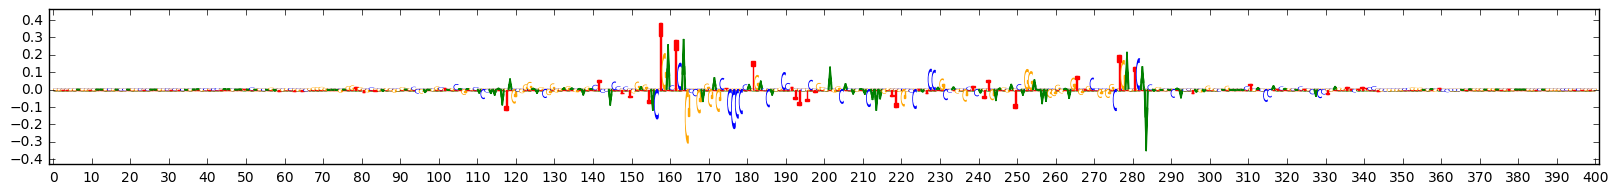

Scores for task 0 for example 197
[ 3.41476189e-05 -1.08503082e-06  5.54479266e-06 -3.28246242e-05
 -4.86612378e-04  4.96290231e-05  2.20839254e-04  2.16065702e-04
  4.70029598e-04  3.72393319e-04  2.94391757e-05  5.98370898e-05
  9.15011216e-04  6.56114018e-04 -8.94831144e-04 -6.77445554e-04
 -2.44125331e-05  1.21890847e-03  7.17092887e-04 -1.04239152e-03
 -2.47459946e-04 -9.49147623e-04 -6.47996785e-04 -3.77823552e-03
 -4.12854087e-03  9.44030471e-04 -2.38166330e-03  7.19888369e-04
  9.81596648e-04  8.31896812e-03 -3.16153746e-05  7.16827996e-03
 -8.62052431e-04 -4.38128039e-03  6.54633110e-03 -1.02060474e-03
  8.60261265e-03  3.31263011e-03 -4.07504570e-03  2.52118148e-03
 -4.17428417e-03 -2.14820786e-04 -1.97984534e-03 -1.01554871e-03
 -2.74493475e-03  3.86055280e-03  1.71559164e-03 -1.60200137e-03
  2.26009870e-05 -2.21770257e-03 -7.77106360e-03  8.17621592e-04
 -4.61079180e-03  3.59946303e-03 -8.12250189e-03 -1.44033479e-02
 -9.34887491e-03  1.67961442e-03 -1.84687541e-03  3.0525

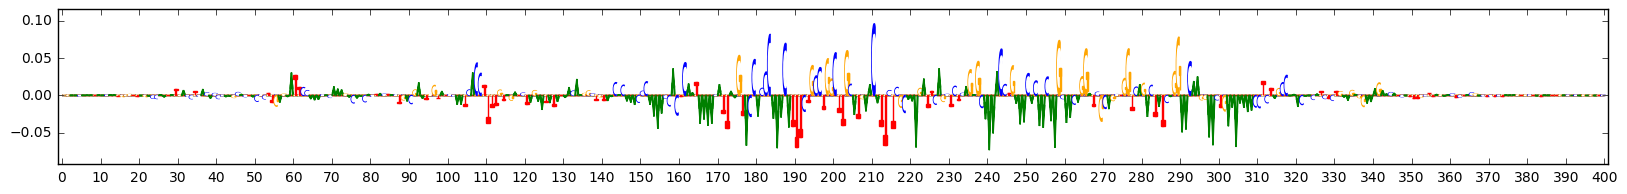

In [41]:
#visualize scores + ground-truth locations of motifs
%matplotlib inline
from deeplift.visualization import viz_sequence

for task, idx in [(0,731), #illustrates failure of grad*inp, integrated grads, deeplift-rescale
                  (0,197)  #illustrates non-specific firing of guided backprop
                 ]:
    print("Scores for task",task,"for example",idx)
    for method_name in [
                        'grad_times_inp',
                        #'integrated_gradients10',
                        #'rescale_all_layers',
                        #'rescale_conv_revealcancel_fc',
                        #'rescale_conv_revealcancel_fc_multiref_10',
                        #'rescale_all_layers_multiref_10'
                        ]:
        scores = method_to_task_to_scores[method_name][task]
        scores_for_idx = scores[idx]
        print(scores_for_idx)
        original_onehot = onehot_data[idx]
        print("Scores shape: " + str(scores_for_idx.shape))
        print("Onehot shape: " + str(original_onehot.shape))
        scores_for_idx = original_onehot*scores_for_idx[:,None]
        print(method_name)
 #       highlight = {'blue':[
 #               (embedding.startPos, embedding.startPos+len(embedding.what))
 #               for embedding in data.embeddings[idx] if 'GATA_disc1' in embedding.what.getDescription()],
 #               'green':[
 #               (embedding.startPos, embedding.startPos+len(embedding.what))
 #               for embedding in data.embeddings[idx] if 'TAL1_known1' in embedding.what.getDescription()]}
        viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10, highlight={})

## Making the scatterplots

I haven't ported the code necessary to generate the scatterplots in the DeepLIFT paper in this version of DeepLIFT. However, for a notebook that reproduces the figures in the paper, feel free to look at https://github.com/kundajelab/deeplift/blob/671ee67a03bd5bebf4c405af59eec45d3ca2a288/examples/public/genomics/genomics_simulation.ipynb